# Algorithm

In [1]:
from leap.example.simple_ea import simple_ea
from leap import core, real, operate as op

def ea(problem, initialize, probes=[], step_notify=[], evals=200, l=2):
    pop_size=5
    mutate_prob=1/l
    mutate_std=0.5

    ea = simple_ea(evals=evals, pop_size=pop_size,
                   individual_cls=core.Individual,  # Use the standard Individual as the prototype for the population.
                   decoder=core.IdentityDecoder(),  # Genotype and phenotype are the same for this task.
                   problem=problem,
                   evaluate=op.evaluate,  # Evaluate fitness with the basic evaluation operator.

                   initialize=initialize,

                   step_notify_list=step_notify,

                   # The operator pipeline.
                   pipeline=probes + [
                       # Select mu parents via tournament selection.
                       op.tournament(n=pop_size),
                       # Clone them to create offspring.
                       op.cloning,
                       # Apply Gaussian mutation to each gene with a certain probability.
                       op.mutate_gaussian(prob=mutate_prob, std=mutate_std, hard_bounds=(-5.12, 5.12))
                   ])
    return ea

# Functions

<IPython.core.display.Javascript object>


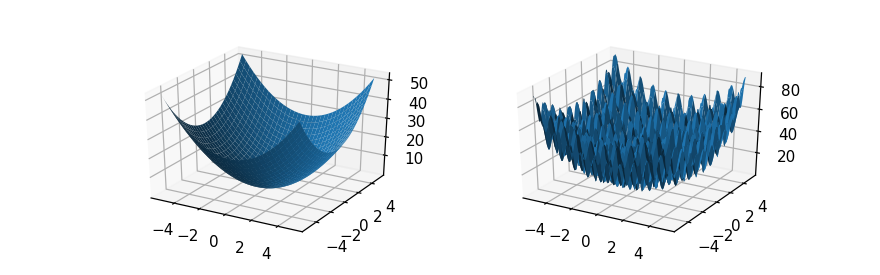

In [2]:
%matplotlib notebook
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from leap import real

problem1 = real.Spheroid()
problem2 = real.Rastrigin(a=10)

plt.figure(figsize=(8, 2.5))
plt.subplot(121, projection='3d')
real.plot_2d_problem(problem1, ax=plt.gca(), xlim=(-5.12, 5.12), ylim=(-5.12, 5.12));
plt.subplot(122, projection='3d')
real.plot_2d_problem(problem2, ax=plt.gca(), xlim=(-5.12, 5.12), ylim=(-5.12, 5.12));

# Single-Task EAs

<IPython.core.display.Javascript object>


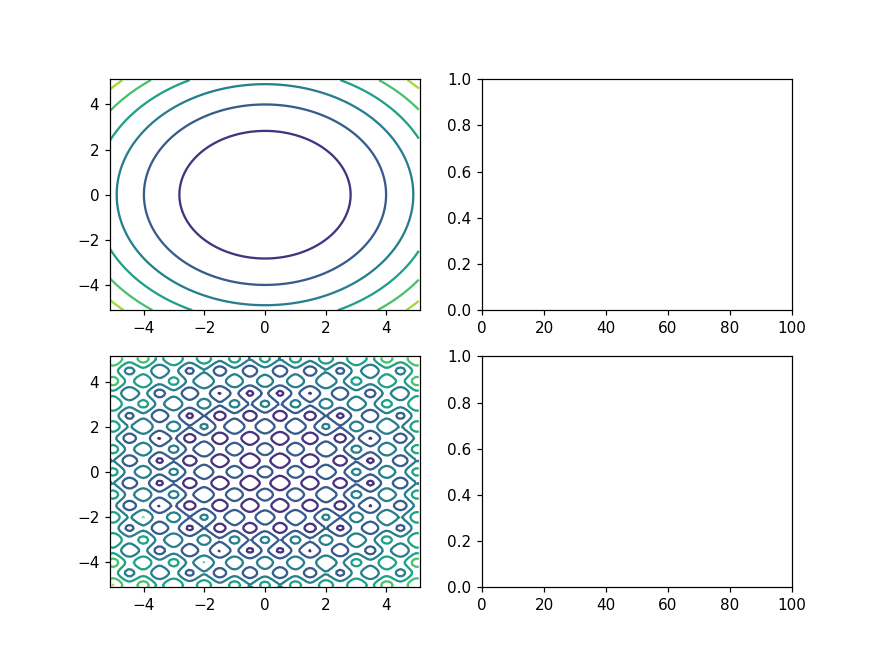

In [3]:
%matplotlib notebook
from leap.probe import PlotTrajectoryProbe, PlotProbe

def quad_probes(modulo):
    plt.figure(figsize=(8, 6))  # Setup a figure to plot to
    plt.subplot(221)
    trajectory_probe_1 = PlotTrajectoryProbe(contours=problem1, xlim=(-5.12, 5.12), ylim=(-5.12, 5.12), granularity=0.1, modulo=modulo, ax=plt.gca())
    plt.subplot(222)
    bsf_probe_1 = PlotProbe(ylim=(0, 1), modulo=modulo, ax=plt.gca())
    plt.subplot(223)
    trajectory_probe_2 = PlotTrajectoryProbe(contours=problem2, xlim=(-5.12, 5.12), ylim=(-5.12, 5.12), granularity=0.1, modulo=modulo, ax=plt.gca())
    plt.subplot(224)
    bsf_probe_2 = PlotProbe(ylim=(0, 1), modulo=modulo, ax=plt.gca())
    return trajectory_probe_1, bsf_probe_1, trajectory_probe_2, bsf_probe_2

trajectory_probe_1, bsf_probe_1, trajectory_probe_2, bsf_probe_2 = quad_probes(50)

In [4]:
random_init = real.initialize_vectors_uniform(bounds=[[-0.5, 0.5]] * 2)

In [5]:
z = zip(ea(problem1, random_init, [trajectory_probe_1, bsf_probe_1], [trajectory_probe_1.set_step, bsf_probe_1.set_step], evals=1000),
        ea(problem2, random_init, [trajectory_probe_2, bsf_probe_2], [trajectory_probe_2.set_step, bsf_probe_2.set_step], evals=1000))
list(z);

# Population Seeding

<IPython.core.display.Javascript object>


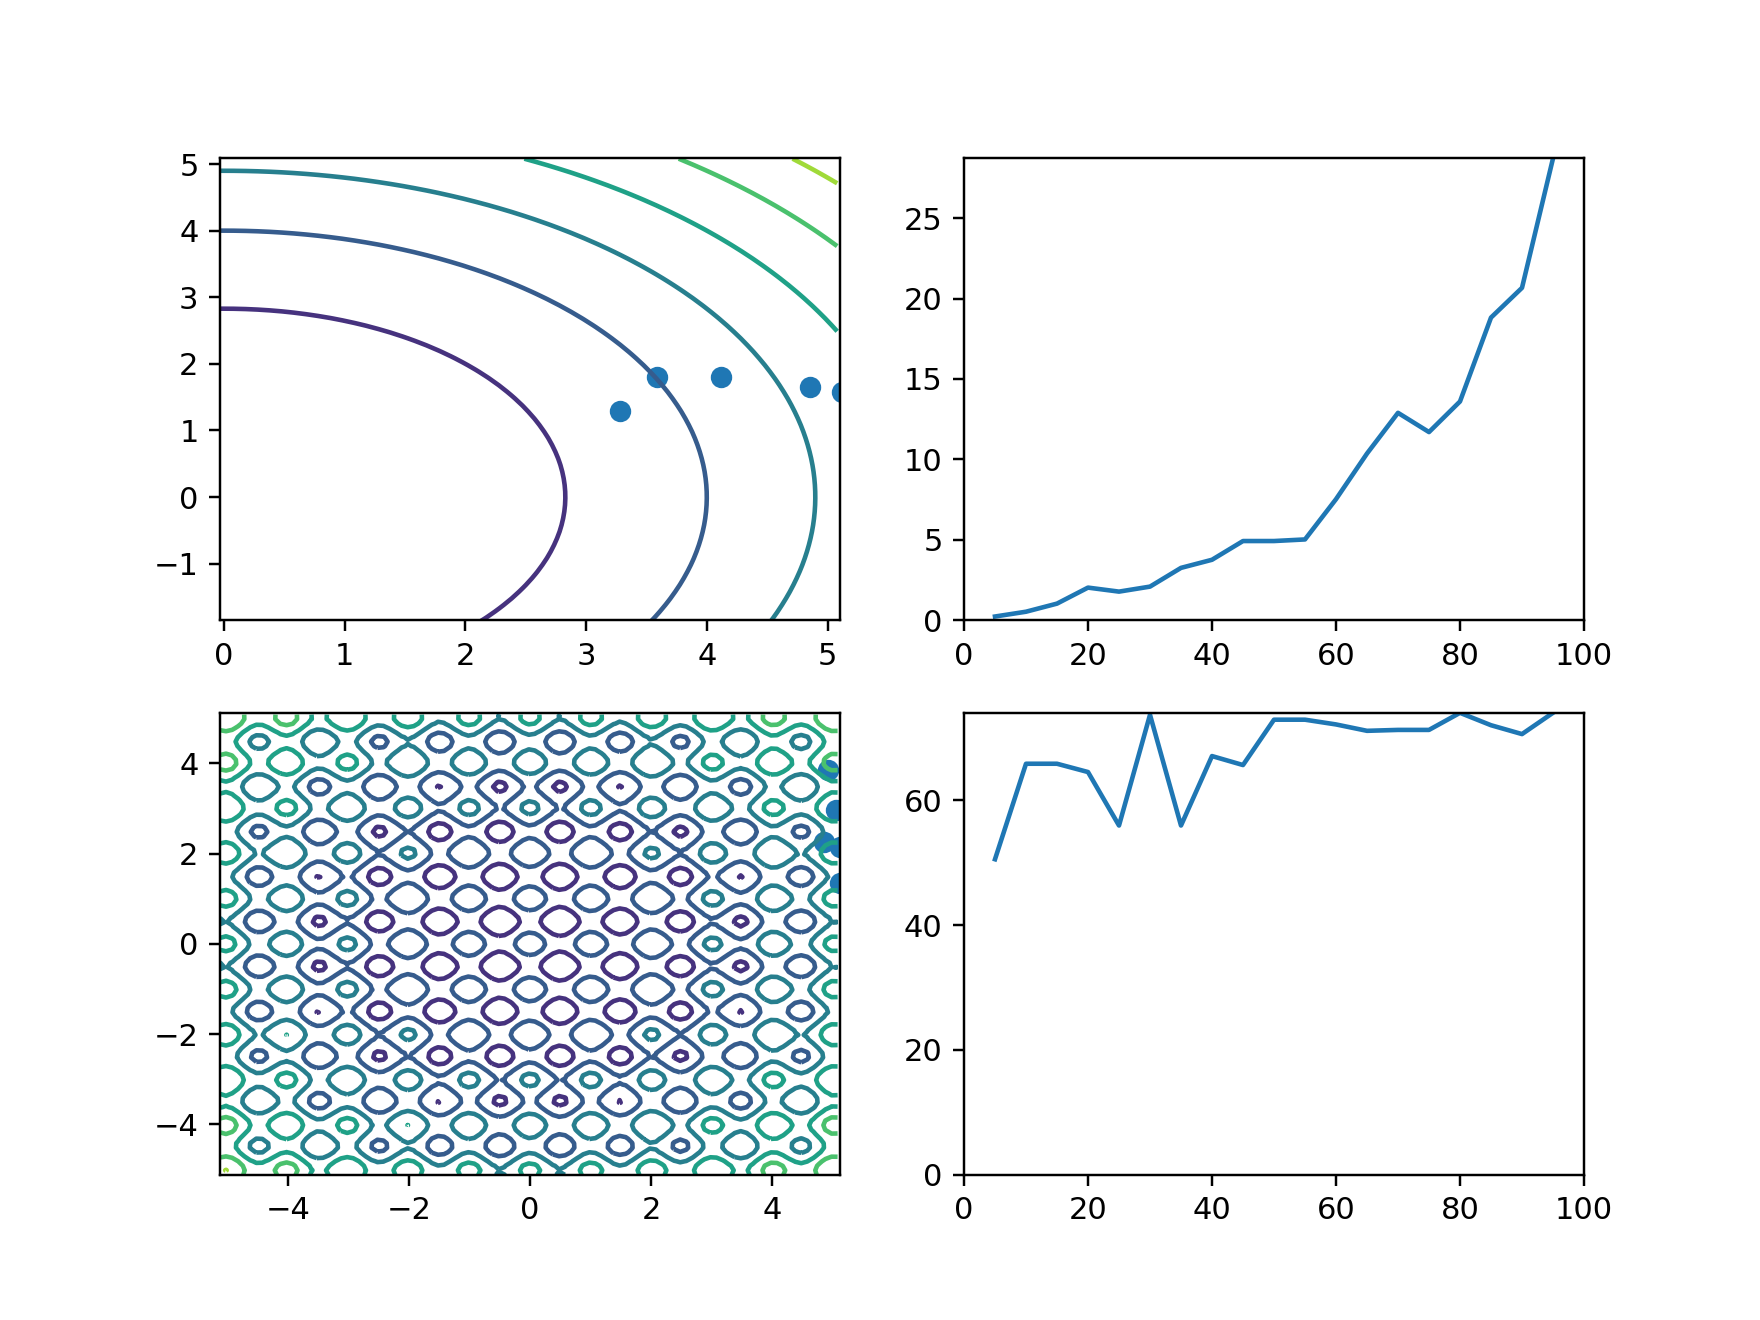

In [6]:
%matplotlib notebook
from leap.probe import PlotTrajectoryProbe, PlotProbe

trajectory_probe_1, bsf_probe_1, trajectory_probe_2, bsf_probe_2 = quad_probes(1)

In [7]:
def initialize_seeded(initialize, seed_pop):
    """A population initializer that injects a fixed list of seed individuals 
    into the population, and fills the remaining space with newly generated individuals."""
    assert(initialize is not None)
    assert(seed_pop is not None)
    
    def f(pop_size):
        assert(pop_size >= len(seed_pop))
        n_new = pop_size - len(seed_pop)
        return seed_pop + initialize(n_new)
    
    return f

#initialize_seeded(random_init, [(5.0, 5.0)])(10)

In [8]:
from toolz import curry

def do_sequential_transfer(ea1, ea2):
    #result = ea(problem1, random_init, [trajectory_probe1, bsf_probe_1], [trajectory_probe1.set_step, bsf_probe_1.set_step], evals=300)
    result = list(ea1())
    best_ind = list(result)[-1][1]
    print("Best ind on source task: " + str(best_ind))
    list(ea2(initialize_seeded(random_init, [best_ind.genome])))
    
    
def ea1():
    return ea(problem1, random_init, [trajectory_probe_1, bsf_probe_1], [trajectory_probe_1.set_step, bsf_probe_1.set_step], evals=100)

def ea2(initialize):
    return ea(problem2, initialize, [trajectory_probe_2, bsf_probe_2], [trajectory_probe_2.set_step, bsf_probe_2.set_step], evals=100)
   
do_sequential_transfer(ea1, ea2)

Best ind on source task: [5.12, 1.653533243439951]


# Multi-Source Population Seeding

<IPython.core.display.Javascript object>


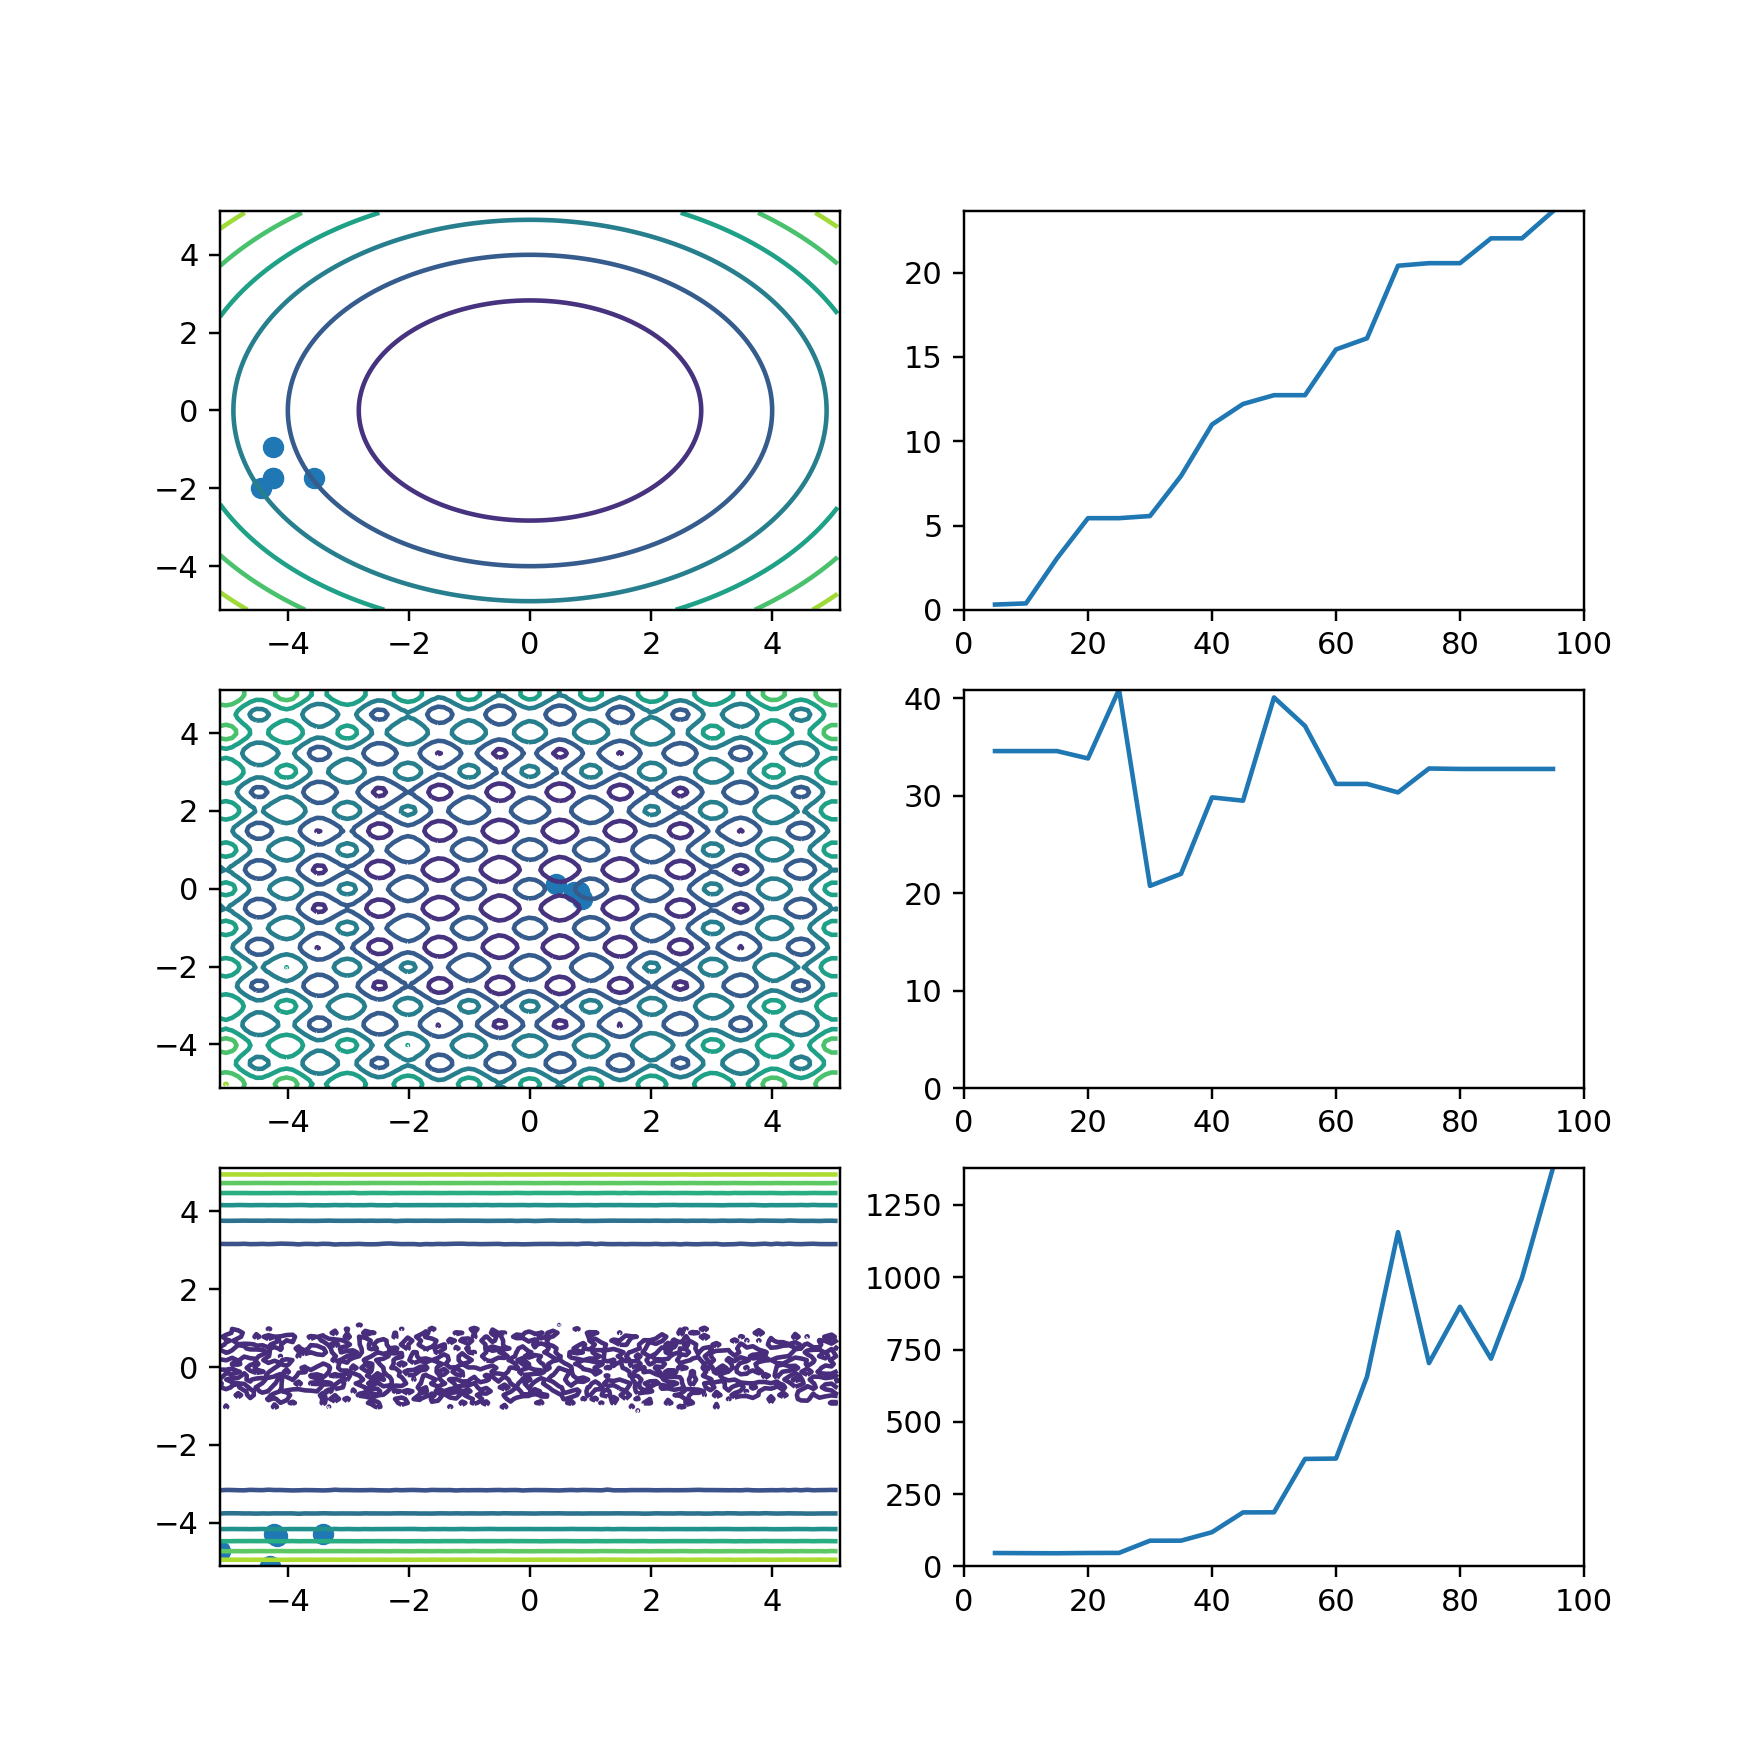

In [9]:
problem3 = real.NoisyQuartic()

def six_probes(modulo):
    plt.figure(figsize=(8, 8))  # Setup a figure to plot to
    plt.subplot(321)
    trajectory_probe_1 = PlotTrajectoryProbe(contours=problem1, xlim=(-5.12, 5.12), ylim=(-5.12, 5.12), granularity=0.1, modulo=modulo, ax=plt.gca())
    plt.subplot(322)
    bsf_probe_1 = PlotProbe(ylim=(0, 1), modulo=modulo, ax=plt.gca())
    plt.subplot(323)
    trajectory_probe_2 = PlotTrajectoryProbe(contours=problem2, xlim=(-5.12, 5.12), ylim=(-5.12, 5.12), granularity=0.1, modulo=modulo, ax=plt.gca())
    plt.subplot(324)
    bsf_probe_2 = PlotProbe(ylim=(0, 1), modulo=modulo, ax=plt.gca())
    plt.subplot(325)
    trajectory_probe_3 = PlotTrajectoryProbe(contours=problem3, xlim=(-5.12, 5.12), ylim=(-5.12, 5.12), granularity=0.1, modulo=modulo, ax=plt.gca())
    plt.subplot(326)
    bsf_probe_3 = PlotProbe(ylim=(0, 1), modulo=modulo, ax=plt.gca())
    return trajectory_probe_1, bsf_probe_1, trajectory_probe_2, bsf_probe_2, trajectory_probe_3, bsf_probe_3

trajectory_probe_1, bsf_probe_1, trajectory_probe_2, bsf_probe_2, trajectory_probe_3, bsf_probe_3 = six_probes(5)

In [10]:
from toolz import curry

def do_multi_transfer(ea1, ea2, ea3):
    #result = ea(problem1, random_init, [trajectory_probe1, bsf_probe_1], [trajectory_probe1.set_step, bsf_probe_1.set_step], evals=300)
    result = list(zip(ea1(), ea2()))
    best_1, best_2 = [x[1] for x in list(result)[-1]]
    print(f"Best ind on source tasks: {best_1}, {best_2}")
    list(ea3(initialize_seeded(random_init, [best_1.genome, best_2.genome])))
    
    
def ea1():
    return ea(problem1, random_init, [trajectory_probe_1, bsf_probe_1], [trajectory_probe_1.set_step, bsf_probe_1.set_step], evals=100)

def ea2():
    return ea(problem2, random_init, [trajectory_probe_2, bsf_probe_2], [trajectory_probe_2.set_step, bsf_probe_2.set_step], evals=100)
   
def ea3(initialize):
    return ea(problem3, initialize, [trajectory_probe_3, bsf_probe_3], [trajectory_probe_3.set_step, bsf_probe_3.set_step], evals=100)
   
do_multi_transfer(ea1, ea2, ea3)

Best ind on source tasks: [-4.795240198532648, -2.1930719159433325], [0.8016402369781028, -0.9068900667343993]
